# Study of Coronavirus Spread
---

Reproduction Number ($R_o$): Estimated $R_o$ for novel coronavirus is **2.9** (between 2.2 to 4.1).

![](https://media.npr.org/assets/img/2014/10/01/ebolar0_custom-51327a6a4853632602173cc2fa7ad8339aac5630-s800-c85.jpg)

After the intial observation, every country tries to apply various restrictions to contain the disease and also develop better clinical methods to reduce fatalities. These efforts lead to reduction in the $R_o$ value. But there are numerous other factors that cause the resurgence of the virus like relaxation in the movement restrictions or evolution and mutation of the virus.  

To capture these features, I have used a **Sigmoid Mixture Model** to fit the data for Total Cases and Deaths. 
$$N=\sum_{i=1}^3 c_i*(Erf(b_i(x-a_i))+1)$$

Where *Erf(x)* is the Error function. If we differentiate N with time,

$$\frac{dN}{dt}=\sum_{i=1}^3 \frac{2b_ic_i}{\sqrt{π}}e^{-b_i^2 (x-a_i)^2} $$
Here every Normal distribution can be thought of as a surge in coronavirus case. Where $c_i$'s represent the magnitude of each surge, $b_i$'s mainly represent the width of the surge but in my formulation can also affect the overall magnitude of the surge. $x=a_i$'s marks the is the 'maxima' of surges in daily cases or the 'inflexion point' in the total Cases.

**General Normal Distribution (CDF)**
$$N=\frac{1}{2}+sgn(x-\mu)\frac{\gamma[\frac{1}{\beta},(\frac{|x-\mu|}{\alpha})^\beta]}{2\Gamma(1/\beta)}$$

**Exponentially Modified Gaussian Distribution(CDF)**
$$N=\Phi(u,0,v)-Exp[-u+v^2/2+log(\Phi (u,v^2,v))]$$
$u=\lambda(x-\mu)$,  $v=\lambda\sigma$
$$\Phi(x;\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}\int_{-\infty}^x e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} = \frac{1}{2}[1+erf(\frac{x-\mu}{\sigma\sqrt{2}})]$$

**Skew Normal Distribution**
$$N=\Phi(\frac{x-\xi}{\omega})-2T(\frac{x-\xi}{\omega},\alpha)$$
Owen's T function T(h,a),
$$T(h,a)=\frac{1}{2\pi}\int_0^a \frac{e^{-\frac{1}{2}h^2(1+x^2)}}{1+x^2}$$
$$\frac{dN}{dt}=\frac{1}{\sqrt{2\pi}}\sum_{i=1}^3 e^{-x^2/2}[1+Erf(\alpha x/\sqrt{2})]$$


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf
from scipy.optimize import curve_fit, dual_annealing

from scipy.ndimage import gaussian_filter

In [0]:
Cases={'World':[580,845,1317,2015,2800,4581,6058,7813,9823,11950,14553,17391,20630,24545,28266,31439,34876,37552,40553,43099,45134,59287,64438,67100,69197,71329,73332,75184,
               75700,76677,77673,78651,79205,80087,80828,81820,83112,84615,86604,88585,90443,93016,95314,98425,102050,106099,109991,114381,118948,126214,134509,145416,156475,
               169517,182414,198159,218744,244902,275550,304979,337459,378830,422574,471035,531865,596366,663127,723390,784741,858361,935232,1015065,1116662,1201483,1272901,
                1348564,1433638,1518126,1603694,1698881,1779842,1852365,1923937,1997903,2082418,2162367,2248864,2330580,2406610,2480506,2556720,2637439,2722857,2828682,2919404,
                2993262,3059944,3136505,3218183,3304220,3395633,3478968,3561228,3640810,3722057,
                3817382,3912156,4009284,4098272,4178097,4252290,4337436,4425666,4522009,4621410,4717009,4799266,4888124,4982937,5082661],
      'USA':[53,57,60,60,63,68,75,100,124,158,221,319,435,541,704,994,1301,1697,2247,2943,3680,4663,6411,9259,13789,19383,24207,33566,43781,54856,68211,85435,104126,123578,
             143491,163788,188530,215003,244877,277161,311357,338425,369635,403095,435030,469124,502876,532879,567708,594693,621953,652474,682454,714822,743901,770014,798145,
             824229,854385,886274,925232,960651,987160,1010356,1035765,1064194,1095023,1131030,1160774,1188122,1212835,1237633,
             1263092,1292623,1321785,1347309,1367638,1385834,1408636,1430348,1457593,1484285,1507773,1527664,1550294,1570583,1591991],
      'Russia':[13,14,17,20,20,28,34,45,59,63,93,114,147,199,253,306,367,438,495,658,840,1036,1264,1534,1836,2337,2777,3548,4149,4731,5389,6343,7497,8672,10131,11917,13584,15770,18328,21102,24490,27938,32008,36793,42853,47121,52763,57999,62773,68622,74588,80949,87147,93558,99399,106498,114431,124054,134687,145268,155370,165929,177160,187859,198676,209688,221344,232243,
                242271,252245,262843,272043,281752,290678,299941,308705],
      'Spain':[2,3,9,13,25,33,58,84,120,165,228,282,401,525,674,1231,1695,2277,3146,5232,6391,7988,9942,11826,14769,18077,21571,25496,28768,35136,42058,49515,57786,65719,
               73235,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027,166831,170099,174060,180659,184948,190839,194416,198674,
               200210,204178,208389,213024,219764,223759,226629,229422,232128,236899,239639,242979,245589,247122,248301,250561,
               253682,256855,260117,262783,264663,268143,269520,271095,272646,274367,276505,277719,278188,278803,279524],
      'UK':[13,16,20,23,36,39,51,87,116,164,209,278,321,383,460,590,798,1140,1391,1543,1950,2626,3269,3983,5018,5683,6650,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718,38168,41903,47806,51608,55242,60733,65077,73758,78991,84279,88621,93873,98476,103093,108692,114217,120067,124743,129044,133495,138078,143464,148377,152840,157149,161145,165221,171253,177454,182260,186599,190584,194990,201101,206715,211364,215260,219183,223060,226463,
            229705,233151,236711,240161,243695,246406,248818,248293],
      'Italy':[157,229,323,470,655,889,1128,1701,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,15113,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138,63927,
               69176,74386,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271,156363,159516,162488,165155,
               168941,172434,175925,178972,181228,183957,187327,189973,192994,195351,197675,199414,201505,203591,205463,207428,209328,210717,211938,213013,
               214457,215858,217185,218268,219070,219814,221216,222104,223096,223885,224760,225435,225886,226699,227364],
      'France':[12,14,18,38,57,100,130,191,212,285,423,653,949,1209,1412,1784,2281,2876,3661,4499,5423,6633,7730,9134,10995,12612,14459,16018,19856,22304,25233,29155,32964,
                37575,40174,44550,52128,56989,59105,76460,83019,87719,90452,99180,103061,107696,113927,118178,120633,124298,130253,133644,146060,147844,150278,153531,155944,
                158183,159828,161488,162100,163273,165911,166420,167178,167346,168396,168693,169462,170551,
                174191,174791,176079,176658,176970,177423,178060,178060,178870,179506,179365,179569,179927,180809,181575],
      'Germany':[16,18,26,48,74,79,130,165,203,262,545,670,800,1040,1224,1565,1966,2745,3675,4599,5813,7272,9367,12327,15320,19848,22364,24873,29056,32991,37323,43938,50871,
                 57695,62435,66885,71808,77981,84794,91159,96092,100123,103375,107663,113296,118235,122171,125452,127854,130072,132210,134753,137698,141397,143724,145742,
                 147065,148453,150648,153129,154999,156513,157770,158758,159912,161539,163009,164077,164967,165664,166152,167007,
                 168162,169430,170588,171324,171879,172576,173171,174098,174975,175699,176244,176651,177289,177827,178531],
      'Iran':[2,5,18,29,43,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,
              23049,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589,64586,66220,68192,70029,71686,73303,74877,76389,77995,79494,
              80868,82211,83505,84802,85996,87026,88194,89328,90481,91472,92584,93657,94640,95646,96448,97424,98647,99970,
              101650,103135,104691,106220,107603,109286,110767,112725,114533,116635,118392,120198,122492,124603,126949],
      'India':[29,30,31,34,40,47,62,62,74,82,100,114,129,143,169,194,249,332,396,499,536,657,727,887,987,1024,1251,1397,1998,2543,3059,3588,4289,4778,5351,5916,6725,7600,
               8446,9205,10453,11487,12370,13430,14352,16365,17615,18539,20080,21370,23039,24447,26283,27890,29451,31324,33062,34863,37257,39699,42505,46437,49400,52987,
               56351,59695,62808,67161,70768,74292,78055,81997,85784,90648,95698,100328,106475,112028],
      'Pakistan':[33,53,184,247,307,454,501,645,776,875,972,1063,1201,1373,1495,1597,1717,1938,2118,2421,2686,2818,3157,3766,4035,4263,4489,4695,5011,5230,5496,5837,6383,
                  6919,7025,7638,8348,8892,9565,10076,11057,11940,12723,13328,13915,14612,15525,16473,18092,19022,20084,20941,22049,
                  23214,24644,26435,28736,30334,30941,32674,35298,35788,37218,38799,40151,42125,43966,45898],
      'Japan':[53,59,66,74,84,94,109,134,146,159,161,172,214,233,241,256,274,293,331,364,420,461,502,530,587,639,691,734,804,833,850,878,914,943,1007,1054,1101,1128,1193,
               1307,1387,1499,1693,1866,1953,2178,2384,2617,2935,3139,3654,3906,4257,4667,5347,6005,6748,7370,7618,7885,8626,9231,9787,10296,10797,11135,11512,11950,12368,12712,13231,13449,13614,13736,13895,14088,14305,14571,14877,15078,15253,
               15253,15477,15575,15663,15777,15847,15968,16049,16120,16203,16237,16285,16305,16367,16367],
      'Maharashtra': [14,32,38,41,44,48,52,64,74,97,107,122,125,156,186,203,220,302,335,423,487,635,747,868,1018,1135,1364,1574,1761,1982,2334,2684,2916,3201,3321,3648,4200,4666,5218,5649,6427,6817,7628,8068,8590,9318,9915,10498,
                       11506,12296,12974,14541,15525,16758,17974,19063,20228,22171,23401,24427,25922,27524,29100,30706,33053,35058,37136,39297],
      'Bangladesh':[3,5,5,8,10,14,18,20,24,27,33,39,39,44,48,48,48,49,51,54,56,61,70,88,123,164,218,330,424,482,621,803,1012,1231,1572,1838,2144,2456,2948,
                    3382,3772,4186,4689,4998,5416,5913,6462,7103,7667,8238,8790,9455,10143,10929,11719,12425,13134,13770,14657,15691,16660,17822,18863,20065,20995,22268,23870,25121,26738],
      'Tamilnadu': [1,2,3,3,6,9,12,18,26,29,38,42,50,67,124,234,309,411,485,571,621,690,738,834,911,969,1075,1173,1204,1242,1267,1323,1372,1477,1520,1596,1629,1683,1755,1821,1885,1937,2058,2162,2323,
                    2526,2757,3023,3550,4058,4829,5409,6009,6535,7204,8002,8718,9227,9674,10108,10585,11224,11760,12448,13191],
      'Gujrat': [2,7,14,18,30,34,38,43,47,55,63,70,74,87,88,95,108,128,146,175,186,262,378,468,516,572,650,766,929,1099,1376,1743,1939,2178,2407,2624,2815,3071,3301,3548,3774,4082,4395,
                 4721,5054,5428,5804,6245,6625,7013,7403,7797,8195,8542,8904,9268,9592,9932,10989,11380,11746,12141,12539],
      'Delhi':[7,7,7,8,10,14,20,27,27,30,30,35,36,40,49,72,97,120,152,293,386,445,503,525,576,669,720,903,1069,1154,1510,1561,1578,1640,1707,1893,2003,2081,2156,2248,2376,2514,2625,2918,3108,3314,3439,3515,
               3738,4122,4549,4898,5104,5532,5980,6318,6542,6923,7233,7639,7998,8470,8895,9333,9755,10054,10554,11088],
      'Rajasthan': [3,4,4,4,7,9,17,24,28,32,32,38,40,50,54,59,79,93,120,133,179,206,266,301,343,383,463,561,700,804,897,1005,1076,1131,1229,1351,1478,1576,1735,1888,1964,2034,2083,2185,2262,2364,2440,2584,
                    2666,2772,2886,3061,3158,3317,3427,3579,3708,3814,3988,4126,4328,4534,4747,4960,5202,5507,5845,6011],
      'Madhya Pradesh':[4,4,6,6,7,15,20,29,39,39,47,66,98,107,154,179,193,256,290,341,411,451,529,562,614,741,938,1164,1310,1402,1407,1485,1552,1587,1687,1846,1945,2090,2165,2387,2560,2625,
                        2715,2788,2837,2942,3049,3138,3252,3341,3457,3614,3785,3986,4173,4426,4595,4790,4977,5236,5465,5735],
      'Uttar Pradesh':[12,13,13,15,17,20,24,28,30,32,35,38,42,49,65,72,96,104,117,128,174,234,278,305,332,361,410,433,452,483,558,660,735,805,849,975,1100,1184,1337,1449,1510,1621,1793,1873,1986,2053,2134,2211,
                       2328,2487,2645,2766,2880,2998,3071,3214,3373,3467,3573,3664,3758,3902,4057,4258,4464,4605,4926,5175],
      'West Bengal':[1,2,4,7,7,9,9,10,15,18,21,22,37,37,53,53,53,80,80,91,99,103,116,126,134,152,190,213,231,255,287,310,339,392,423,456,514,571,611,649,697,725,758,
                     795,922,1198,1259,1344,1456,1548,1678,1786,1939,2063,2173,2290,2377,2461,2576,2677,2824,2961,3103],
      'Bihar':[2,3,3,4,7,9,11,15,15,21,24,29,31,32,32,32,38,39,58,60,64,64,66,66,72,83,85,86,96,113,126,143,170,223,251,277,346,366,403,425,
               466,481,517,528,535,542,550,579,611,707,749,879,953,999,1033,1178,1320,1423,1519,1607]
      }
Deaths={'World':[17,25,41,56,80,106,132,170,213,259,304,362,426,492,565,638,724,813,910,1018,1115,1261,1383,1526,1669,1775,1873,2009,2126,2247,2360,2460,2618,2699,2763,2800,2858,2923,2977,3050,3117,3202,3285,3387,3494,3599,3827,4025,4296,4628,4981,5428,5834,6524,7170,7990,8972,10063,11440,13084,14735,16647,19071,21515,24392,27758,31395,34733,38699,43407,48490,54677,60609,66623,71604,77081,84721,91360,98804,105979,112265,117881,123493,130635,138744,145574,153915,160364,165356,170735,177675,184299,190915,197095,203164,
                 206915,210239,214748,221436,228029,233824,239447,244664,248144,252240,258026,264837],
        'India':[1,2,2,2,2,3,3,4,5,5,7,10,10,12,20,20,24,27,32,35,58,72,86,99,118,136,160,178,227,249,288,331,358,393,422,448,486,521,559,592,645,681,721,780,825,881,939]
}

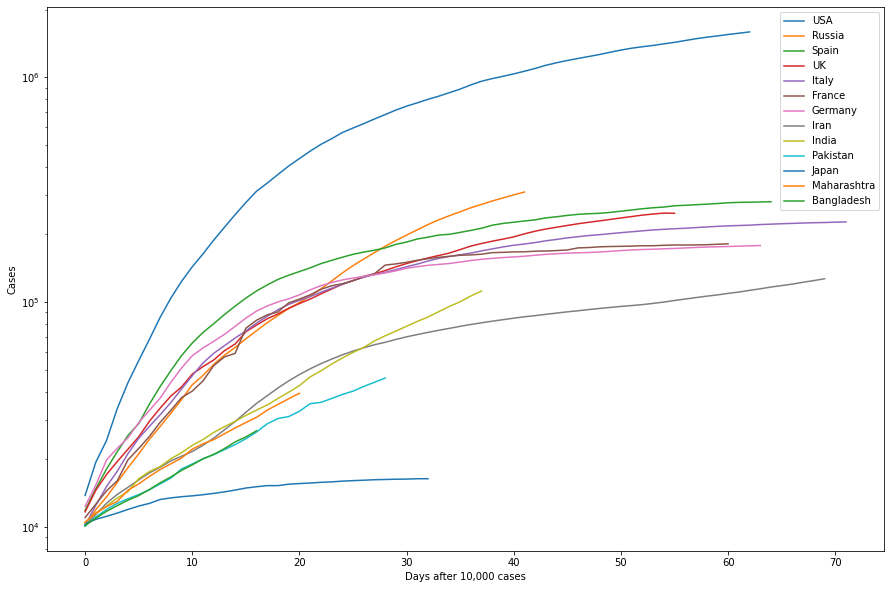

In [8]:
plt.figure(figsize=(15,10))
for key in Cases.keys():
  if key=='World': continue
  temp=np.array(Cases[key])
  temp=temp[temp>10000]
  if len(temp)>10:
    plt.semilogy(temp,label=key)
plt.xlabel('Days after 10,000 cases')
plt.ylabel('Cases')
plt.legend()
plt.show()

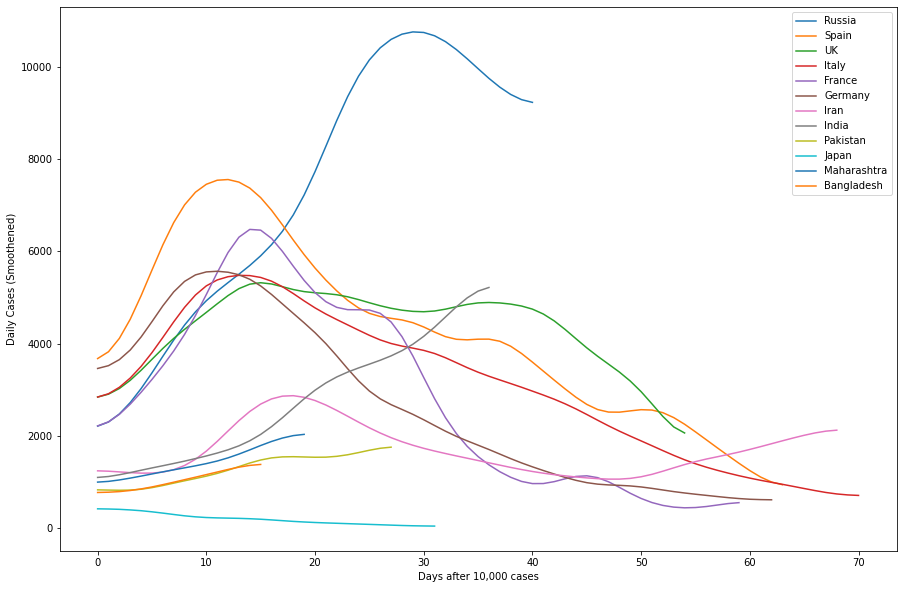

In [29]:
plt.figure(figsize=(15,10))
for key in Cases.keys():
  if key in ['World','USA']: continue
  temp=np.array(Cases[key])
  temp=temp[temp>10000]
  if len(temp)>10:
    plt.plot(gaussian_filter(temp[1:]-temp[:-1],3),label=key)
plt.xlabel('Days after 10,000 cases')
plt.ylabel('Daily Cases (Smoothened)')
plt.legend()
plt.show()

# Recent Exponential Trends

Doubling rate:
{'Bihar': 9.1, 'Tamilnadu': 9.4, 'Maharashtra': 11.2, 'Bangladesh': 11.5, 'West Bengal': 12.1, 'India': 12.6, 'Delhi': 13.4, 'Gujrat': 14.3, 'Pakistan': 14.4, 'Russia': 14.5, 'Rajasthan': 16.1, 'Madhya Pradesh': 16.6, 'Uttar Pradesh': 18.0, 'World': 33.1, 'UK': 39.2, 'USA': 39.6, 'Iran': 45.5, 'Spain': 88.4, 'Japan': 108.8, 'Italy': 147.1, 'Germany': 153.2, 'France': 168.2}


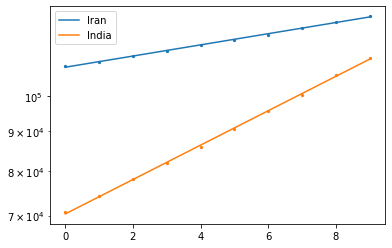

In [30]:
from collections import OrderedDict

Doubling_Rate={}
def f(x,A,M):
  return A*np.exp(M*x)

for key in Cases.keys():
  y=Cases[key][-20:]
  x=np.arange(len(y))
  popt,pcov=curve_fit(f,x,y)
  Doubling_Rate[key]=round(np.log(2)/popt[1],1)

print("Doubling rate:")
Doubling_Rate={k: v for k, v in sorted(Doubling_Rate.items(), key=lambda item: item[1])}
print(Doubling_Rate)

for key in ['Iran', 'India']:
  y=Cases[key][-10:]
  x=np.arange(len(y))
  popt,pcov=curve_fit(f,x,y)
  plt.scatter(x,y,s=5)
  plt.semilogy(x,f(x,popt[0],popt[1]),label=key)
plt.legend()
plt.show()

In [0]:
def plot(param,x,y,key):
  x_new=np.arange(len(y)+30)
  n=len(param)//3
  res=0
  sat=0
  for i in range(n):
    [a,b,c]=param[3*i:3*(i+1)]
    sat+=c
    res+=c*(erf(b*(x_new-a))+1)
  
  print(key)
  print("Saturation: ",2*int(sat))

  fig, axs = plt.subplots(1, 2, figsize=(10,4))
  axs[0].scatter(x,y,s=5)
  axs[0].plot(x_new,res,c='r')
  axs[0].set_title('Cumulative Coronavirus Cases')
  axs[1].plot(x_new[1:],res[1:]-res[:-1],c='r')
  axs[1].scatter(x[1:],y[1:]-y[:-1],s=5)
  axs[1].set_title('Daily Coronavirus Cases')

  axs[1].set(ylim=[0,1.1*max(res[1:]-res[:-1])])

  for ax in axs.flat:
      ax.set(xlabel='Days')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()
  
  plt.show()

In [0]:
def f1(x,a,b,c):
  return c*(erf(b*(x-a))+1)
def f2(x,a1,b1,c1,a2,b2,c2):
  return c1*(erf(b1*(x-a1))+1)+c2*(erf(b2*(x-a2))+1)
def f3(x,a1,b1,c1,a2,b2,c2,a3,b3,c3):
  return c1*(erf(b1*(x-a1))+1)+c2*(erf(b2*(x-a2))+1)+c3*(erf(b3*(x-a3))+1)
def f4(x,a1,b1,c1,a2,b2,c2,a3,b3,c3,a4,b4,c4):
  return c1*(erf(b1*(x-a1))+1)+c2*(erf(b2*(x-a2))+1)+c3*(erf(b3*(x-a3))+1)+c4*(erf(b4*(x-a4))+1)

In [0]:
def df1(x,a,b,c):
  return c*np.exp(-(x-a)**2/b)
def df2(x,a,b,c,alpha):
  return c*np.exp(-(x-a)**2/b)*(erf((x-a)*alpha)+1)
def df3(x,a1,b1,c1,a2,b2,c2):
  return c1*np.exp(-(x-a1)**2/b1)+c2*np.exp(-(x-a2)**2/b2)
def df4(x,a1,b1,c1,a2,b2,c2,alpha):
  return c1*np.exp(-(x-a1)**2/b1)*(erf((x-a1)/alpha)+1)+c2*np.exp(-(x-a2)**2/b2)*(erf((x-a2)/alpha)+1)

Maharashtra
Saturation:  160730


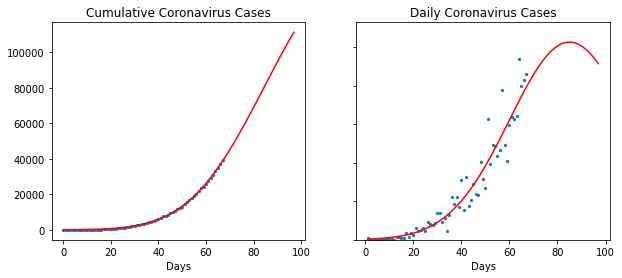

Bangladesh
Saturation:  59022


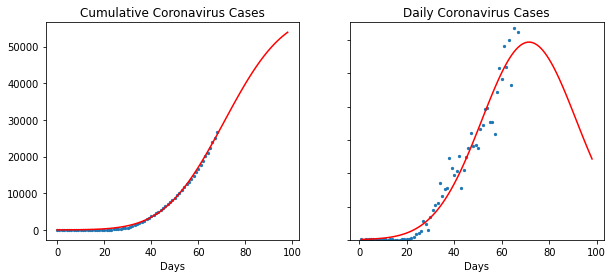

Gujrat
Saturation:  18038


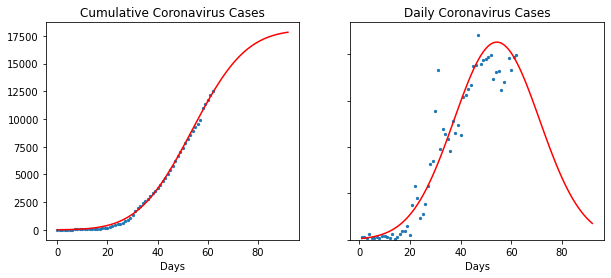

Rajasthan
Saturation:  9870


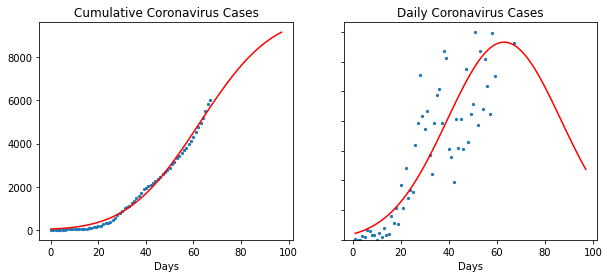

Tamilnadu
Saturation:  14264


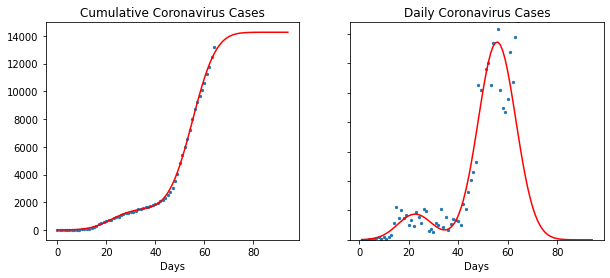

Delhi
Saturation:  16360


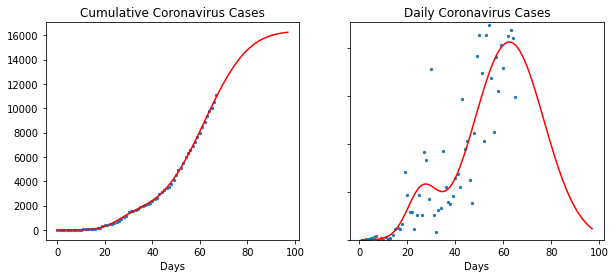

In [57]:
for key in ['Maharashtra', 'Bangladesh', 'Gujrat', 'Rajasthan']:
  y=np.array(Cases[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f1,x,y)
  except: continue

  plot(popt,x,y,key)
for key in ['Tamilnadu', 'Delhi']:
  y=np.array(Cases[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f2,x,y)
  except: continue

  plot(popt,x,y,key)

Russia
Saturation:  354048


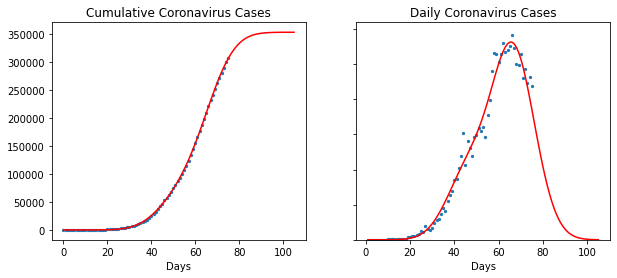

Spain
Saturation:  285882


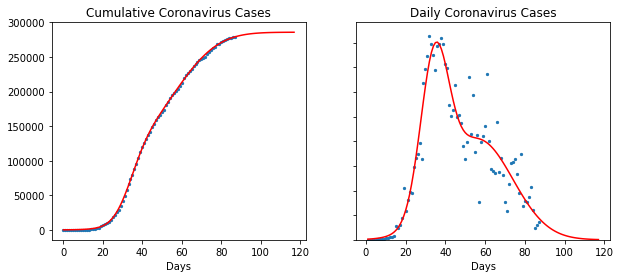

UK
Saturation:  260996


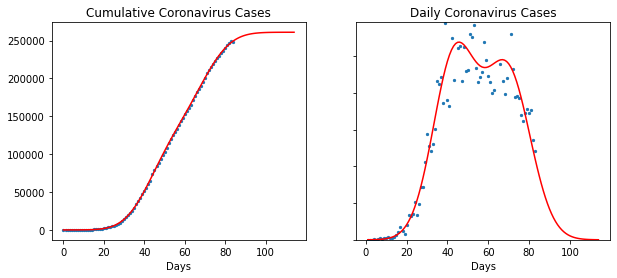

Italy
Saturation:  227858


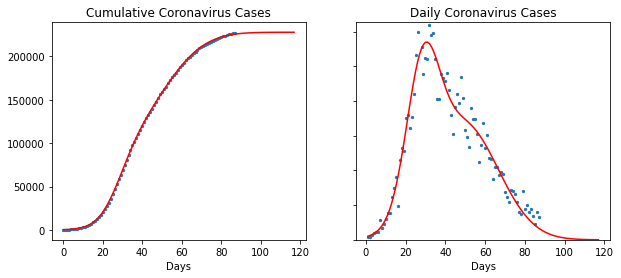

France
Saturation:  187210


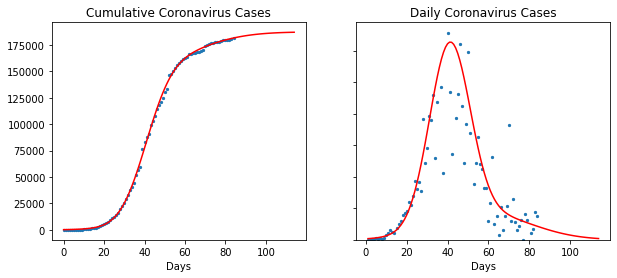

Germany
Saturation:  178910


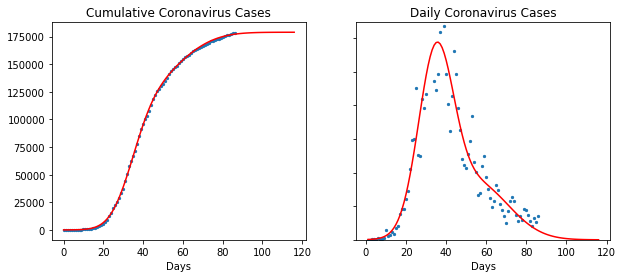

India
Saturation:  329352


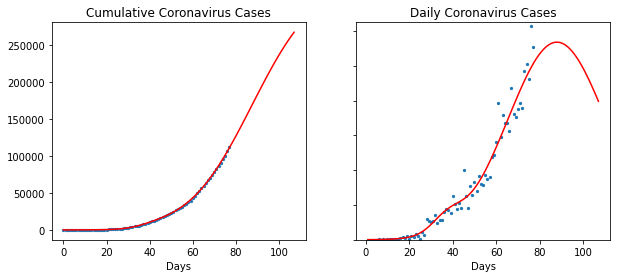

Pakistan
Saturation:  74204


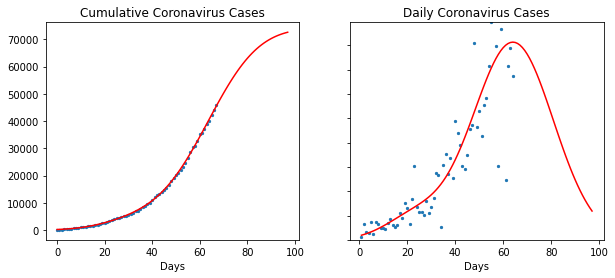

Japan
Saturation:  18560


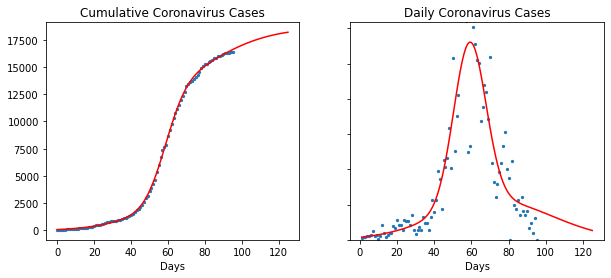

In [49]:
for key in ['Russia', 'Spain', 'UK', 'Italy', 'France', 'Germany', 'India', 'Pakistan', 'Japan']:
  y=np.array(Cases[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f2,x,y)
  except: continue

  plot(popt,x,y,key)

USA
Saturation:  1647472


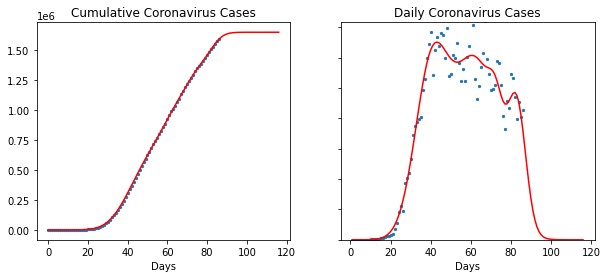

Iran
Saturation:  170962


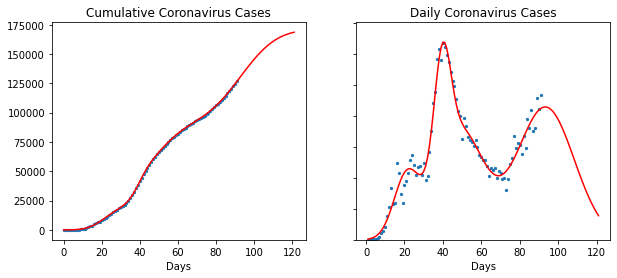

In [52]:
for key in ['World', 'USA', 'Iran']:
  y=np.array(Cases[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f4,x,y)
  except: continue

  plot(popt,x,y,key)